# Working with output from many different CMIP6 climate models

***This demonstration is modified from Abernathy: Earth and Environmental Data Science - [Working with CMIP 6 Models](https://earth-env-data-science.github.io/lectures/models/cmip.html)***  

In this demonstration we will learn how to quickly search and analyze CMIP6 data with [Pangeo](https://pangeo.io/) tools in the cloud, a process that using the 'download and analyze' workflow often becomes prohibitively slow and inefficient due to the sheer scale of the data.

However, scientist have developed and shared tools that allow for efficient analysis of cloud-stored data. **It is even possible to run these on a laptop, even though we are sifting through terrabytes of data.** 

The basis for this workflow are the analysis-ready-cloud-optimized repositories of CMIP6 data, which are currently maintained by the pangeo community and publicly available on both [Google Cloud Storage](https://medium.com/pangeo/cmip6-in-the-cloud-five-ways-96b177abe396) and [Amazon S3](https://www.youtube.com/watch?v=C0UhiiGgbWA&t=3267s) as a collection of [zarr](https://zarr.readthedocs.io/en/stable/) stores.

The cloud native approach enables scientific results to be fully reproducible, encouraging to build onto and collaborate on scientific results.  

## Learning Goals

- See how global climate data can be accessed and processed right from your laptop
- Discuss differences in CMIP model temperature projections

In [1]:
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import matplotlib.pyplot as plt

The first thing we have to do is to get an overview of all the data available. In this case we are using [intake-esm](https://intake-esm.readthedocs.io/en/stable/index.html) to load a collection of zarr stores on Google Cloud Storage, but there are [other options](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html) to access the data too.

Lets create a collection object and look at it


In [2]:
col = google_cmip_col()
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


This object describes all the available data (over 500k single zarr stores!). The rows describe different 'facets' that can be used to search and query subsets of the data. For detailed info on each of the facets please refer to this [document](https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit).

So obviously we never want to work with *all* the data. Lets check out how to get a subset. 

First we need to understand a bit better what all these facets mean and how to see which ones are in the full collection. Lets start with the `experiment_id`: This is the prescribed forcing for a particular MIP that is exactly the same across all different models. We can look at the values of the collection as a pandas dataframe to convieniently list all values.

In [3]:
col.df['experiment_id'].unique()

array(['highresSST-present', 'piControl', 'control-1950', 'hist-1950',
       'historical', 'amip', 'abrupt-4xCO2', 'abrupt-2xCO2',
       'abrupt-0p5xCO2', '1pctCO2', 'ssp585', 'esm-piControl', 'esm-hist',
       'hist-piAer', 'histSST-1950HC', 'ssp245', 'hist-1950HC', 'histSST',
       'piClim-2xVOC', 'piClim-2xNOx', 'piClim-2xdust', 'piClim-2xss',
       'piClim-histall', 'hist-piNTCF', 'histSST-piNTCF',
       'aqua-control-lwoff', 'piClim-lu', 'histSST-piO3', 'piClim-CH4',
       'piClim-NTCF', 'piClim-NOx', 'piClim-O3', 'piClim-HC',
       'faf-heat-NA0pct', 'ssp370SST-lowCH4', 'piClim-VOC',
       'ssp370-lowNTCF', 'piClim-control', 'piClim-aer', 'hist-aer',
       'faf-heat', 'faf-heat-NA50pct', 'ssp370SST-lowNTCF',
       'ssp370SST-ssp126Lu', 'ssp370SST', 'ssp370pdSST', 'histSST-piAer',
       'piClim-ghg', 'piClim-anthro', 'faf-all', 'hist-nat', 'hist-GHG',
       'ssp119', 'piClim-histnat', 'piClim-4xCO2', 'ssp370',
       'piClim-histghg', 'highresSST-future', 'esm-ssp585-

The experiments you are probably most interested in are the following:
- `piControl`: In most cases this is the 'spin up' phase of the model, where it is run with a constant forcing (representing pre-industrial greenhouse gas concentrations)
- `historical`: This experiment is run with the observed forcing in the past. 
- `ssp***`: A set of ["Shared Socioeconomic Pathways"](https://www.sciencedirect.com/science/article/pii/S0959378016300681) which represent different combined scenarios of future greenhouse gas emissions and other socio-economic indicators ([Explainer](https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change/)). These are a fairly complex topic, but to simplify this for our purposes here we can treat `ssp585` as the 'worst-case' and `ssp245` as 'middle-of-the-road'.

You can explore the available models (`source_id`) in the same way as above:

In [4]:
col.df['source_id'].unique()

array(['CMCC-CM2-HR4', 'EC-Earth3P-HR', 'HadGEM3-GC31-MM',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM', 'EC-Earth3P', 'ECMWF-IFS-HR',
       'ECMWF-IFS-LR', 'HadGEM3-GC31-LL', 'CMCC-CM2-VHR4', 'GFDL-CM4',
       'GFDL-AM4', 'IPSL-CM6A-LR', 'E3SM-1-0', 'CNRM-CM6-1', 'GFDL-ESM4',
       'GFDL-ESM2M', 'GFDL-CM4C192', 'GFDL-OM4p5B', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'CNRM-ESM2-1', 'BCC-CSM2-MR', 'BCC-ESM1', 'MIROC6',
       'AWI-CM-1-1-MR', 'EC-Earth3-LR', 'IPSL-CM6A-ATM-HR', 'CESM2',
       'CESM2-WACCM', 'CNRM-CM6-1-HR', 'MRI-ESM2-0', 'SAM0-UNICON',
       'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'EC-Earth3', 'EC-Earth3-Veg',
       'FGOALS-f3-L', 'CanESM5', 'CanESM5-CanOE', 'INM-CM4-8',
       'INM-CM5-0', 'NESM3', 'MPI-ESM-1-2-HAM', 'CAMS-CSM1-0',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-AGCM3-2-H', 'MRI-AGCM3-2-S',
       'MCM-UA-1-0', 'INM-CM5-H', 'KACE-1-0-G', 'NorESM2-LM',
       'FGOALS-f3-H', 'FGOALS-g3', 'MIROC-ES2L', 'FIO-ESM-2-0', 'NorCPM1',
       'NorESM1-F', 'MPI-ESM1-2-XR'

Now you want to decide what variable (`variable_id`) you want to look at and in conjunction what time frequency of output (`table_id`) is available. This handy [spreadsheet](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271) can help you find the value for `variable_id` and the available time frequencies (`table_id`).  

Lets look at an example for monthly (`'table_id'='Omon'`) sea surface temperature (`'variable_id'='tos'`) for the `historical` experiment: 

In [5]:
cat = col.search(
    variable_id='tos', # ocean surface temperature
    table_id='Omon',
    experiment_id='historical',
    source_id=['GFDL-ESM4'],
)
cat

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,3
table_id,1
variable_id,1
grid_label,2
zstore,6
dcpp_init_year,0


The last facet we need to discuss is `member_id` and `grid_label`: 
You can see here that we have 3 `member_id` values for the given query. 

In [6]:
cat.df['member_id'].unique()

array(['r3i1p1f1', 'r2i1p1f1', 'r1i1p1f1'], dtype=object)

This indicates that for this particular model/experiment 3 ensemble members where run with varing realizations/initial_condiditions/physics/forcing or a combination thereof. The naming is explained in [this](https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit)document:
> Example of a variant_label:  if realization_index=2, initialization_index=1, physics_index=3, and forcing_index=233, then variant_label = “r2i1p3f233”.

There can be many more members for some particular models, which provides an opportunity to investigate internal variability of the climate system as compared to forced signals.

Finally there are two values of `grid_label`

In [7]:
cat.df['grid_label'].unique()

array(['gr', 'gn'], dtype=object)

The value `gn` always stands for the native model grid (which can be quite complex but preserves the most detail) and `gr` indicates data that has been regridded on regular lon/lat intervals.

Now that you know how to query and subset the collection, it is time to actually load in some model data as xarray datasets!

In [8]:
# create a smaller catalog from the full collection using faceted search
cat = col.search(
    variable_id='tos', # Ocean surface temperature
    experiment_id='historical', # only runs for the historical forcing period
    table_id='Omon', # monthly oceanic data
    grid_label='gn', #native model grid only
    source_id=['IPSL-CM6A-LR', 'MRI-ESM2-0', 'GFDL-ESM4'], # only choosing a few models here, there are many more!
    member_id=['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'], #lets restrict us here to only a few members, you can modify this later to experiment.
)

# read all datasets into a dictionary but apply the xmip preprocessing before
ddict = cat.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


c:\Users\jessr\anaconda3\envs\cmip\Lib\site-packages\xmip\preprocessing.py:96: UserWarning: CMIP.MRI.MRI-ESM2-0.historical.r1i1p1f1.Omon.gn.none.tos:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
c:\Users\jessr\anaconda3\envs\cmip\Lib\site-packages\xmip\preprocessing.py:96: UserWarning: CMIP.MRI.MRI-ESM2-0.historical.r1i1p1f1.Omon.gn.none.tos:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
c:\Users\jessr\anaconda3\envs\cmip\Lib\site-packages\xmip\preprocessing.py:96: UserWarning: CMIP.MRI.MRI-ESM2-0.historical.r2i1p1f1.Omon.gn.none.tos:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
c:

Here we did two things: 
- We searched the full collection based on a combination of facets like the variable, the experiment and only a test set of models.
- We loaded the datasets into a dictionary of xarray datasets (note they are not loaded into memory, but instead these are lazyly loaded dask arrays -- more on this in the following lectures).

In [9]:
list(ddict.keys())

['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gn',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn']

You can see that we have three different models. Lets look at them in a bit more detail to understand the layout:

In [10]:
ddict['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn']

<xarray.Dataset> Size: 3GB
Dimensions:         (y: 332, x: 362, member_id: 3, dcpp_init_year: 1,
                     time: 1980, vertex: 4, bnds: 2)
Coordinates: (12/13)
    area            (y, x) float32 481kB dask.array<chunksize=(332, 362), meta=np.ndarray>
    lat             (y, x) float32 481kB dask.array<chunksize=(332, 362), meta=np.ndarray>
    lon             (y, x) float32 481kB dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    lon_verticies   (y, x, vertex) float32 2MB dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lat_verticies   (y, x, vertex) float32 2MB dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    ...              ...
  * y               (y) int64 3kB 0 1 2 3 4 5 6 ... 325 326 327 328 329 330 331
  * x               (x) int64 3kB 0 1 2 3 4 5 6 ... 355 356 357 358 359 360 361
    lon_bounds      (bnds, y, x) float32 961kB dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    lat_bounds      (bnds, y, x) float32 961kB dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
  * member_id       (member_id) object 24B 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: vertex, bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, y, x) float32 3GB dask.array<chunksize=(1, 1, 251, 332, 362), meta=np.ndarray>
Attributes: (12/52)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            historical
    NCO:                              "4.6.0"
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20180803
    intake_esm_attrs:_data_format_:   zarr
    variant_info:                     Restart from another point in piControl...
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn

In [11]:
ddict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn']

<xarray.Dataset> Size: 10GB
Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 1980, y: 576,
                     x: 720, bnds: 2, vertex: 4)
Coordinates:
    lat             (y, x) float32 2MB dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon             (y, x) float32 2MB dask.array<chunksize=(576, 720), meta=np.ndarray>
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
  * x               (x) float64 6kB -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * y               (y) float64 5kB -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
    time_bounds     (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_verticies   (y, x, vertex) float32 7MB dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    lon_verticies   (y, x, vertex) float32 7MB dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    lon_bounds      (bnds, y, x) float32 3MB dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    lat_bounds      (bnds, y, x) float32 3MB dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
  * member_id       (member_id) object 24B 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds, vertex
Data variables:
    tos             (member_id, dcpp_init_year, time, y, x) float32 10GB dask.array<chunksize=(1, 1, 64, 576, 720), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omo...

You can see that both datasets have the same names for many of the coordinates (e.g. 'x' and 'y' for the logical indices in zonal and meridional direction). This is actually not always the case for the raw CMIP6 data, which is why [xMIP](https://github.com/jbusecke/xMIP) was developed in an effort to crowdsource these common data-cleaning tasks. For this example we only use the `combined_preprocessing` function which fixes some of the naming, but check out the [docs](https://cmip6-preprocessing.readthedocs.io/en/latest/?badge=latest) to see more helpful code for CMIP analysis.

Ok but now lets analyze the data! 

### A first plot
We can create a simple plot, right from data in the cloud!

So far, we have not yet loaded any data into our computer's memory. 

This is a bit of a difficult concept to understand, but all operations above, just pointed to the correct data. As soon as we execute the cell below, which creates an output (i.e. the plot), the data to create this plot will be downloaded and loaded into the computers memory. Therefore, plotting taks a bit of time.  

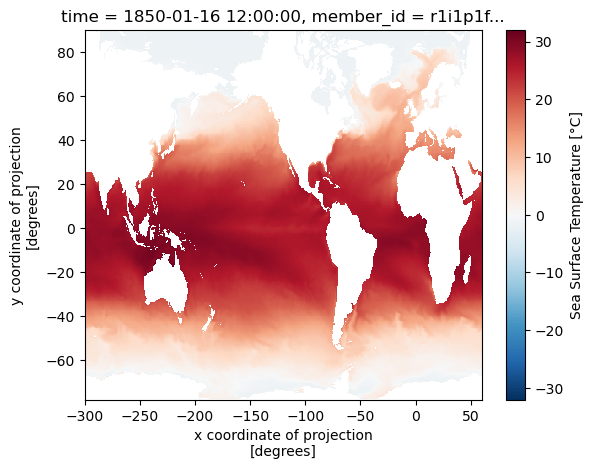

In [12]:
ddict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn'].isel(time=0).sel(member_id = 'r1i1p1f1').tos.plot()

Using what we know about xarray we can get a timeseries of the global sea surface temperature:

Making these plots requires a bit more time, as more data needs to be downloaded and processed. 

CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn


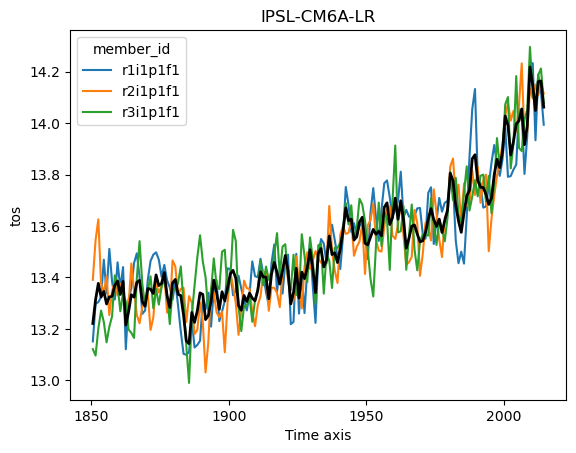

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn


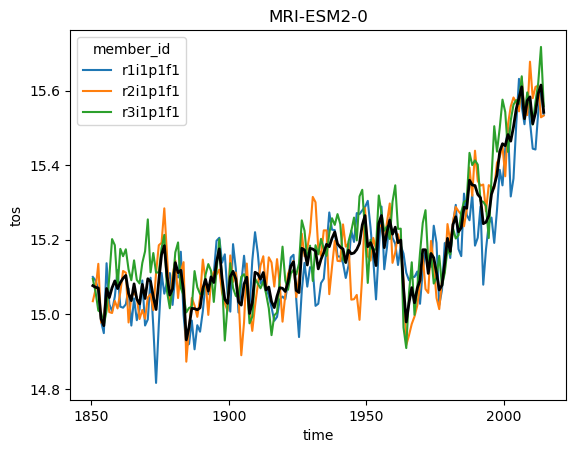

CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn


_request out of retries on exception: [WinError 10053] An established connection was aborted by the software in your host machine
Traceback (most recent call last):
  File "c:\Users\jessr\anaconda3\envs\cmip\Lib\site-packages\gcsfs\retry.py", line 126, in retry_request
    return await func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jessr\anaconda3\envs\cmip\Lib\site-packages\gcsfs\core.py", line 424, in _request
    async with self.session.request(
  File "c:\Users\jessr\anaconda3\envs\cmip\Lib\site-packages\aiohttp\client.py", line 1194, in __aenter__
    self._resp = await self._coro
                 ^^^^^^^^^^^^^^^^
  File "c:\Users\jessr\anaconda3\envs\cmip\Lib\site-packages\aiohttp\client.py", line 605, in _request
    await resp.start(conn)
  File "c:\Users\jessr\anaconda3\envs\cmip\Lib\site-packages\aiohttp\client_reqrep.py", line 966, in start
    message, payload = await protocol.read()  # type: ignore[union-attr]
                       ^^^^^^^^^

ClientPayloadError: Response payload is not completed

<Figure size 640x480 with 0 Axes>

In [13]:
for name, ds in ddict.items():
    print(name)
    # construct yearly global mean timeseries
    mean_temp = ds.tos.mean(['x', 'y']).coarsen(time=12).mean()
    plt.figure()
    mean_temp.plot(hue='member_id')
    # lets also plot the average over all members
    mean_temp.mean('member_id').plot(color='k', linewidth=2)
    plt.title(ds.attrs['source_id']) #Extract the model name right from the dataset metadata
    plt.show()

But wait! This is not exactly right. We need to weight the spatial mean by the area of each grid cell, since the area varies based on the position on the globe (and the particularities of the curvilinear grid used in each model). But we can easily query the cell area (by modifying the query from above slightly) and then match them to the data using xmip

In [ ]:
# Repeat the above steps to get the cell area matching the temperature we loaded earlier
cat_area = col.search(
    variable_id='areacello', # the cell area is a different variable in the collection
    table_id='Ofx', # since area is not varying in time we need to specify a different table_id
    experiment_id='historical', # Same as before
    grid_label='gn', # Same as before
    source_id=['IPSL-CM6A-LR', 'MRI-ESM2-0', 'GFDL-ESM4'], # Same as before
    member_id=['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'], # Same as before
)
# read all datasets into a dictionary (make sure to apply the same preprocessing as before!)
ddict_area = cat_area.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True}
) 

In [ ]:
list(ddict_area.keys())

You can inspect the new dictionary `ddict_area` and will find that the structure is very similar to the one for surface temperature above.

In [ ]:
ddict_w_area = match_metrics(ddict, ddict_area, 'areacello', dim_length_conflict='align')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xmip/postprocessing.py:593: UserWarning: CMIP.NOAA-GFDL.GFDL-ESM4.historical.none.Omon.gn.none.tos:`metric` dimensions ['member_id:1'] do not match `ds` ['member_id:3']. Aligning the data on `inner`
  warnings.warn(msg + " Aligning the data on `inner`")


In [ ]:
ddict_w_area['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gn']

<xarray.Dataset>
Dimensions:         (x: 720, y: 576, time: 1980, member_id: 1,
                     dcpp_init_year: 1, vertex: 4, bnds: 2)
Coordinates: (12/13)
  * x               (x) float64 -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * y               (y) float64 -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    lat             (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    ...              ...
    lon             (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon_verticies   (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon_bounds      (bnds, y, x) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    lat_bounds      (bnds, y, x) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    areacello       (member_id, dcpp_init_year, y, x) float32 dask.array<chunksize=(1, 1, 576, 720), meta=np.ndarray>
Dimensions without coordinates: vertex, bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 64, 576, 720), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omo...

Ok the dataset now has a matching `areacello` coordinate that we can use to weight our results. To see the effect of area weighting we will plot both timeseries (only the member average).

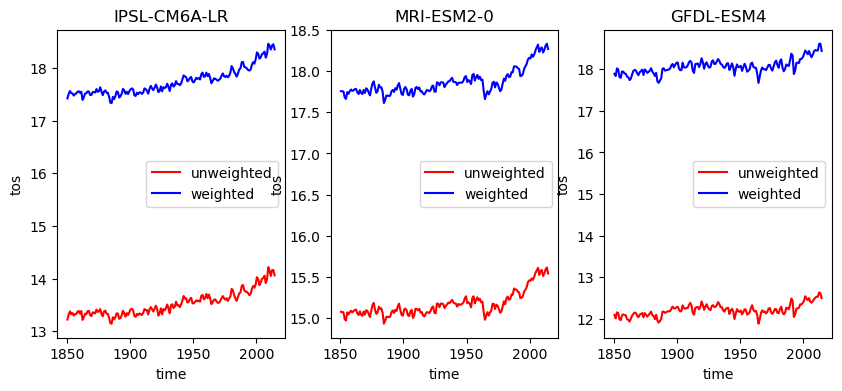

In [ ]:
plt.figure(figsize=[10, 4])
for i, (name, ds) in enumerate(ddict_w_area.items()):
    plt.subplot(1,3,i+1)
    # construct yearly global mean timeseries
    mean_temp = ds['tos'].mean(['x', 'y']).coarsen(time=12).mean()
    weights = ds.areacello.fillna(0) # ocean area can contain nans, which are not allowed for weighting
    mean_temp_weighted = ds['tos'].weighted(weights).mean(['x', 'y']).coarsen(time=12).mean()
    # lets look at the difference
    mean_temp.mean('member_id').plot(label = 'unweighted', color='r')
    mean_temp_weighted.mean('member_id').plot(label = 'weighted', color='b')
    plt.title(ds.attrs['source_id'])
    plt.legend()

Quite the difference! This makes sense when we think about the fact that generally cells near the poles become smaller, and if we do a naive mean, these will count too strongly into the global value and reduce the resulting temperature.

Ok lets finish by making a single nice plot of all models. In order to compare the models better we will look at the anomaly of temperature with regard to the period of 1850-1900.

Text(0.5, 1.0, 'Global average sea surface temperature')

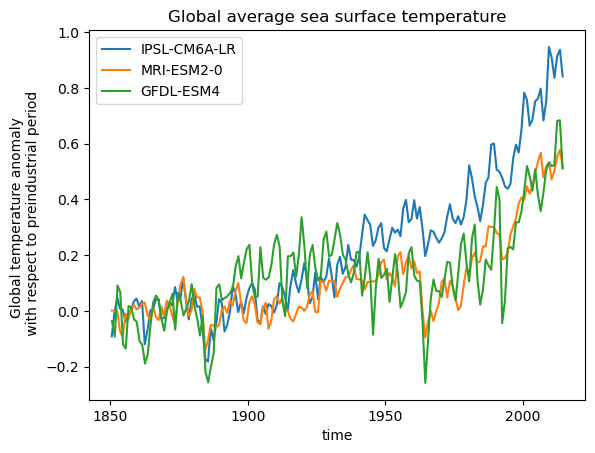

In [ ]:
plt.figure()
timeseries_dict = {}
for name, ds in ddict_w_area.items():
    # construct yearly global mean timeseries
    weights = ds.areacello.fillna(0)
    mean_temp_weighted = ds['tos'].weighted(weights).mean(['x', 'y']).coarsen(time=12).mean()
    anomaly = mean_temp_weighted - mean_temp_weighted.sel(time=slice('1850', '1900')).mean('time')
    anomaly.mean('member_id').plot(label = ds.attrs['source_id'])
plt.legend()
plt.ylabel('Global temperature anomaly \n with respect to preindustrial period')
plt.title('Global average sea surface temperature')